# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

The aim of this project is to build a classifier with Deep Learning. 
The input data consists of raw pictures of traffic signs. The pictures need to be preprocessed, the CNN architecture will be defined and the training will also occur here.

This ipython file contains everything required to achieve this goal from loading the data to the evaluating the classification.

Moreover, you can find a writeup in this repository.

---
## Step 0: Load The Data

Loading the given datasets of german traffic signs and splitting it into train, valid and test data.

It isn't part of this repository, but can be downloaded here: http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset

In [2]:
# Load pickled data
import pickle

training_file = '../datasets/traffic-signs-data/train.p'
validation_file= '../datasets/traffic-signs-data/valid.p'
testing_file = '../datasets/traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
import numpy as np
import csv

n_train = y_train.size 
n_validation = y_valid.size
n_test = y_test.size
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = np.unique(train['labels']).size

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Dataset visualization

This section is to show an example output of the training set. Here, you can select the dataset and the imgnumber. 

The result will be shown below.

You can modify section "Select your image". There a dataset as well as the img/label number can be specified.

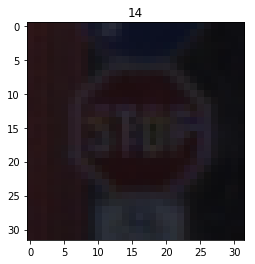

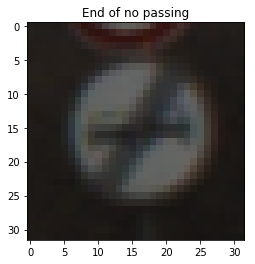

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

def display_img(img, title):
    fig, ax = plt.subplots()
    ax.imshow(img)
    ax.set_title(title)
    plt.show()

def display_example_label(dataset, label):
     # Signname mapping
    with open('signnames.csv', mode='r') as csvfile:
        reader = csv.reader(csvfile)
        signnameDict = {rows[0]:rows[1] for rows in reader}
    for imgNumber, it_label in enumerate(dataset['labels']):
        if(label==it_label):
            display_img(dataset['features'][imgNumber], str(label))
            break;

def display_img_of_dataset(dataset,imgNumber):
    # Signname mapping
    with open('signnames.csv', mode='r') as csvfile:
        reader = csv.reader(csvfile)
        signnameDict = {rows[0]:rows[1] for rows in reader}
    image=dataset['features'][imgNumber]
    title=signnameDict[str(dataset['labels'][imgNumber])]
    display_img(image,title)
    
# Select your image
display_example_label(train,14)
display_img_of_dataset(train,14)

### Class distribution
The following will show the distribution classes over the different datasets. The evaluation is based on the number of the labels. 

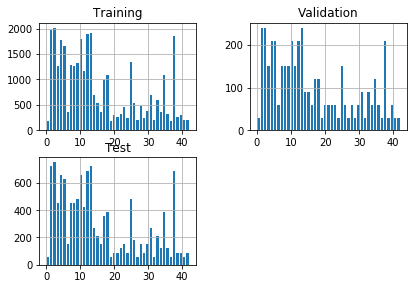

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

#Plot a distribution over the classes
#Training
plt.subplot(221)
plt.title('Training')
plt.grid(True)
hist, bins = np.histogram(y_train, bins=n_classes)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)

#Validation
plt.subplot(222)
plt.title('Validation')
plt.grid(True)
hist, bins = np.histogram(y_valid, bins=n_classes)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)

#Test
plt.subplot(223)
plt.title('Test')
plt.grid(True)
hist, bins = np.histogram(y_test, bins=n_classes)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)

plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

A starting point here is the famous LeNet CNN architecture from Yann LeCunn. But it will be enhanced with the architecture from [this paper](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It is promising (and also proven) that the performance of this enhanced LeNet architecture is much higher than a conversative approach.

With the LeNet-5 solution from the lecture, a accuracy of about 0.89 is to expect but with the new architecture a accuracy of 0.96 can be achieved.

### Preprocess the dataset

The preprocessing consists of two steps: Grayscale and normalization

For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

In [10]:
import numpy as np
from sklearn.preprocessing import normalize

def preprocess(x_data):
    # Grayscale
    x_data_gry = np.sum(x_data/3, axis=3, keepdims=True)

    # Normalization
    x_data = (x_data - 128)/128 
    return x_data_gry

X_train=preprocess(X_train)
X_valid=preprocess(X_valid)

# Shuffle is needed
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

print ('preprocessing finished')

preprocessing finished


### Model Architecture
Implementing the paper "Traffic Sign Recognition with Multi-Scale Convolutional Networks" (Pierre Sermanet and Yann LeCun).
The keypoint is the 2-stage ConvNet architecture. 

In [7]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
        
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    W1 = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma), name="W1")
    b1 = tf.Variable(tf.zeros(6), name="b1")

    x = tf.nn.conv2d(x, W1, strides=[1, 1, 1, 1], padding='VALID')
    x = tf.nn.bias_add(x, b1)
    x = tf.nn.relu(x)
    
    # Pooling. Input = 28x28x6. Output = 14x14x6.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Layer 2: Convolutional. Output = 10x10x16.
    W2 = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma), name="W2")
    b2 = tf.Variable(tf.zeros(16), name="b2")

    x = tf.nn.conv2d(x, W2, strides=[1, 1, 1, 1], padding='VALID')
    x = tf.nn.bias_add(x, b2)
    x = tf.nn.relu(x)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    layer2 = x # Saving it for later
    
    # Layer 3: Convolutional. Output = 1x1x400.
    W3 = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 400), mean = mu, stddev = sigma), name="W3")
    b3 = tf.Variable(tf.zeros(400), name="b3")

    x = tf.nn.conv2d(x, W3, strides=[1, 1, 1, 1], padding='VALID')
    x = tf.nn.bias_add(x, b3)
    x = tf.nn.relu(x)
    layer3 = x # Saving it for later

    # Flatten. Input = 5x5x16. Output = 400.
    layer2flat = flatten(layer2)
    
    # Flatten x. Input = 1x1x400. Output = 400.
    layer3flat = flatten(layer3)
    
    # Concat layer2flat and x. Input = 400 + 400. Output = 800
    x = tf.concat([layer3flat, layer2flat], 1)
    
    # Dropout
    x = tf.nn.dropout(x, keep_prob)
    
    # Layer 4: Fully Connected. Input = 800. Output = 120.
    W4 = tf.Variable(tf.truncated_normal(shape=(800, 120), mean = mu, stddev = sigma), name="W4")
    b4 = tf.Variable(tf.zeros(120), name="b4")    
    x = tf.add(tf.matmul(x, W4), b4)
    x = tf.nn.relu(x)

    # Layer 5: Fully Connected. Input = 120. Output = 84.
    W5 = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    b5 = tf.Variable(tf.zeros(84)) 
    x = tf.add(tf.matmul(x, W5), b5)
    x = tf.nn.relu(x)

    # Layer 6: Fully Connected. Input = 84. Output = 43.
    W6 = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    b6 = tf.Variable(tf.zeros(43)) 
    x = tf.add(tf.matmul(x, W6), b6)
    
    return x

C:\Users\alext\AppData\Local\conda\conda\envs\carnd1\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


### Train, Validate and Test the Model

This part trains the CNN based on the training data and validate the trained classifier with the validation dataset.

Here, the performance of the CNN architecture can be evaluated. 

Finally, the trained model is saved and can be used for further processes.

In [8]:
import tensorflow as tf
from sklearn.utils import shuffle

EPOCHS = 40
BATCH_SIZE = 128

keep_prob = tf.placeholder(tf.float32) # probability to keep units
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

# Model Evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

saver = tf.train.Saver()

# Train the Model
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y,keep_prob: 0.2})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()

    saver.save(sess, './lenet')
    print("Model saved")

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

Training...

EPOCH 1 ...
Validation Accuracy = 0.055

EPOCH 2 ...
Validation Accuracy = 0.049

EPOCH 3 ...
Validation Accuracy = 0.073

EPOCH 4 ...
Validation Accuracy = 0.056

EPOCH 5 ...
Validation Accuracy = 0.155

EPOCH 6 ...
Validation Accuracy = 0.309

EPOCH 7 ...
Validation Accuracy = 0.407

EPOCH 8 ...
Validation Accuracy = 0.577

EPOCH 9 ...
Validation Accuracy = 0.642

EPOCH 10 ...
Validation Accuracy = 0.720

EPOCH 11 ...
Validation Accuracy = 0.759

EPOCH 12 ...
Validation Accuracy = 0.774

EPOCH 13 ...
Validation Accuracy = 0.812

EPOCH 14 ...
Validation Accuracy = 0.854

EPOCH 15 ...
Validation Accuracy = 0.849

EPOCH 16 ...
Validation Accuracy = 0.850

EPOCH 17 ...
Validation Accuracy = 0.882

EPOCH 18 ...
Validation Accuracy = 0.894

EPOCH 19 ...
Validation Accuracy = 0.903

EPOCH 20 

---

## Step 3: Test a Model on New Images

In order to test the trained model, images from German traffic signs are downloaded partially from the real world and partially in the perfect shape (paint).

First, these images need to be resized that the classifier can handle them and then the prediction is compared with the ground truth (labelDict).

### Load and Preprocess Test images

In [11]:
from PIL import Image
import glob
import os
from sklearn.metrics import accuracy_score

# Read in the file in the test_images folder
fileList=glob.glob("./test_images/*.jpg")

# Ground truth mapping
labelDict={}
labelDict['30.jpg']=1
labelDict['50.jpg']=2
labelDict['70.jpg']=4
labelDict['end_of_speedlimit.jpg']=32
labelDict['no_entry.jpg']=17
labelDict['priority_road.jpg']=12
labelDict['stop.jpg']=14
labelDict['yield.jpg']=13

# Resize the image to the size of the training data
def resizeimg(img):
    new_img = img.resize((32,32))
    new_img=np.asarray(new_img)
    return new_img

# Preprocess the test_images
X_testNew=[]
for imgfile in fileList:
    X_testNew.append(resizeimg(Image.open(imgfile)))
X_testNew=preprocess(np.array(X_testNew))

print ("Test image preprocessing done")

Test image preprocessing done


### Predict the Sign Type for Each Image

Here, the trained classifier from above will be loaded and classify the provided internet test images.

The probability and the label of the five most likely predictions for each image is saved in Top5predicted.

In [27]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    # Highest prediction
    prediction=tf.argmax(logits,1)
    predictionResult=(prediction.eval(feed_dict={x: X_testNew, keep_prob: 1}))

    # Top 5 probabilities
    proba=tf.nn.softmax(logits)
    probaList=proba.eval(feed_dict={x: X_testNew, keep_prob: 1})
    TopK = tf.nn.top_k(probaList, 5)
    Top5predicted=sess.run(TopK)

INFO:tensorflow:Restoring parameters from .\lenet


### Analyze Performance

Based on the prediction from the previous section, the performance will be evaluated.

You can see that there is a correlation between the uncertainty of the classificator and the potential for wrong predictions.

In [28]:
# Evaluation of the predictions
groundtruth=[]
for i, file in enumerate(fileList):
    print ("\n")
    print ("File: " + os.path.basename(file))
    print ("Ground truth:" + str(labelDict[os.path.basename(file)]))
    groundtruth.append(labelDict[os.path.basename(file)])
    print ("Prediction:" + str(predictionResult[i]))
    print ("Top5 predicted labels:" + str(Top5predicted.indices[i]))
    print ("Top5 probabilities:" + str(Top5predicted.values[i]))

# Total accuracy
print ("\n")
print ("Total accuracy: " + str(accuracy_score(groundtruth, predictionResult)))



File: 30.jpg
Ground truth:1
Prediction:1
Top5 predicted labels:[ 1  0 40  2 11]
Top5 probabilities:[9.9375689e-01 6.2420331e-03 4.8484281e-07 2.9142035e-07 1.7845628e-07]


File: 50.jpg
Ground truth:2
Prediction:1
Top5 predicted labels:[ 1  2 14  3  4]
Top5 probabilities:[9.9007320e-01 9.8337596e-03 4.0987539e-05 1.6931805e-05 1.6894724e-05]


File: 70.jpg
Ground truth:4
Prediction:0
Top5 predicted labels:[ 0  4  1 37 40]
Top5 probabilities:[9.7510296e-01 2.2235917e-02 2.1429667e-03 5.1701482e-04 1.0233765e-06]


File: end_of_speedlimit.jpg
Ground truth:32
Prediction:1
Top5 predicted labels:[ 1  0 40 32 12]
Top5 probabilities:[9.7686827e-01 1.8583670e-02 2.0801176e-03 1.3870742e-03 4.7876406e-04]


File: no_entry.jpg
Ground truth:17
Prediction:17
Top5 predicted labels:[17 40 33 12 14]
Top5 probabilities:[1.00000000e+00 9.32692463e-17 1.08299345e-19 3.77302991e-20
 2.30514024e-20]


File: priority_road.jpg
Ground truth:12
Prediction:12
Top5 predicted labels:[12 13 40 35 14]
Top5 proba